In [1]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization,Activation, Flatten, \
Conv3D,MaxPooling3D,Input,GlobalAveragePooling3D, Conv2D, MaxPooling2D,LSTM,TimeDistributed, \
Conv1D,MaxPooling1D,Input, LSTM
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model,X_test,y_test,type_cm,display_labels,cmap=plt.cm.Blues,normalize=True):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)
    c_mat = confusion_matrix(y_test,y_pred)
    if normalize:
        c_mat = np.round(c_mat.astype('float') / c_mat.sum(axis=1)[:, np.newaxis],4)
    plt.imshow(c_mat, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix'+type_cm)
    plt.colorbar()
    tick_marks = np.arange(len(display_labels))
    plt.xticks(tick_marks, display_labels, rotation=0)
    plt.yticks(tick_marks, display_labels)
    thresh = c_mat.max() / 2.
    for i, j in itertools.product(range(c_mat.shape[0]), range(c_mat.shape[1])):
        plt.text(j, i, c_mat[i, j],
                 horizontalalignment="center",
                 color="white" if c_mat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def disp_confusion_matrix(model,X,y,type_cm,class_label):
    disp = plot_confusion_matrix(model, X, y, type_cm,display_labels=class_label,
                                 cmap=plt.cm.Blues)
    
def results(lr,model,model_name,epochs=100,verb=1,batch_size=30):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy',optimizer=opt,
             metrics=['accuracy'])
    history = model.fit(X_train,y_train, epochs = epochs, batch_size=batch_size,\
                        shuffle=False, verbose=verb,validation_data=(X_test,y_test))
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Costo vs Época')
    plt.ylabel('Costo')
    plt.xlabel('Época')
    plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Precisión del modelo')
    plt.ylabel('Precisión')
    plt.xlabel('Época')
    plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
    plt.show()
    disp_confusion_matrix(model,X_test,y_test,model_name,class_label=['Left Hand','Right Hand','Neutral']) 

In [33]:
def kfold_val(model,X,y,n_splits,model_epochs,model_batch_size,X__t,y__t,name):
    kfold = StratifiedKFold(n_splits=n_splits,shuffle=False)
    cvscores = []
    y = np.argmax(y,axis=1)+1
    i = 1
    for train,test in kfold.split(X,y):
        y_train =tf.keras.utils.to_categorical(y[train]-1)
        y_test =tf.keras.utils.to_categorical(y[test]-1)
        #Compile the model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        #Fit the model on the train split
        model.fit(X[train],y_train,verbose=0,epochs=model_epochs,batch_size=model_batch_size)
        #Evaluate the model
        score = model.evaluate(X[test],y_test,verbose=0)
        print(f'KFold_{i} '+"%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
        cvscores.append(score[1])
        i+=1
    print('Validated accuracy: '+"%.2f%% (+/- %.2f%%)" % (np.mean(cvscores)*100, np.std(cvscores)))
    #Validation set information
    print('Test set accuracy')
    ev = model.evaluate(X__t,y__t,verbose=0)[1]
    print("%s: %.2f%%" % (model.metrics_names[1], ev*100))
    disp_confusion_matrix(model,X__t,y__t,name,class_label=['Left Hand','Right Hand','Neutral'])
    return cvscores

In [3]:
def load_dataset(dataset):
    if dataset == 'cwt':
        path ='Pre-Dat/Fp1-F3-P4-O2-A1-T3'
        extension = ''
        X_train = np.load(path+'/X_train'+f'{extension}.npy')
        X_test = np.load(path+'/X_test'+f'{extension}.npy')
        y_train = np.load(path+'/y_train'+f'{extension}.npy')
        y_test = np.load(path+'/y_test'+f'{extension}.npy')
    elif dataset == 'raw_1':
        path ='Pre-Dat/Raw/Fp1-Fp2-F3-F4-C3-C4-P3-P4-O1-O2-A1-A2-F7-F8-T3-T4-T5-T6-Fz-Cz-Pz'
        extension = ''
        X_train = np.load(path+'/X_train'+f'{extension}.npy')
        X_test = np.load(path+'/X_test'+f'{extension}.npy')
        y_train = np.load(path+'/y_train'+f'{extension}.npy')
        y_test = np.load(path+'/y_test'+f'{extension}.npy')
    elif dataset =='raw_2':
        path ='Pre-Dat/Raw/Fp1-Fp2-F3-F4-C3-C4-P3-P4-O1-O2-A1-A2-F7-F8-T3-T4-T5-T6-Fz-Cz-Pz'
        extension = ''
        X_train = np.load(path+'/X_train'+f'{extension}.npy')
        X_test = np.load(path+'/X_test'+f'{extension}.npy')
        y_train = np.load(path+'/y_train'+f'{extension}.npy')
        y_test = np.load(path+'/y_test'+f'{extension}.npy')
        n_steps, n_length,n_features = 8, 25,X_train.shape[2]
        X_train = X_train.reshape([X_train.shape[0],n_steps,n_length,n_features])
        X_test = X_test.reshape([X_test.shape[0],n_steps,n_length,n_features])
    elif dataset == 'ssa_1':
        path ='Pre-Dat/SSA/Fp1-F3-P4-O2-A1-T3'
        extension = ''
        X_train = np.load(path+'/X_train'+f'{extension}.npy')
        X_test = np.load(path+'/X_test'+f'{extension}.npy')
        y_train = np.load(path+'/y_train'+f'{extension}.npy')
        y_test = np.load(path+'/y_test'+f'{extension}.npy')        
    elif dataset =='ssa_2':
        path ='Pre-Dat/SSA/Fp1-F3-P4-O2-A1-T3'
        extension = ''
        X_train = np.load(path+'/X_train'+f'{extension}.npy')
        X_test = np.load(path+'/X_test'+f'{extension}.npy')
        y_train = np.load(path+'/y_train'+f'{extension}.npy')
        y_test = np.load(path+'/y_test'+f'{extension}.npy')
        n_steps, n_length,n_features = 8, 25,X_train.shape[2]
        X_train = X_train.reshape([X_train.shape[0],n_steps,n_length,n_features])
        X_test = X_test.reshape([X_test.shape[0],n_steps,n_length,n_features])
    return X_train,y_train,X_test,y_test

In [4]:
class models:
    def __init__(self):
        pass
    
    def LSTM_model_ssa(self,n_steps=200,n_features=6,activation='tanh',dense_activation='hard_sigmoid',dropout_rate=0.5,batch_normalization=True,init_mode='glorot_normal'):
        model = Sequential()
        model.add(Input(shape=(n_steps,n_features)))
        model.add(LSTM(150,activation=activation,return_sequences=True))
        model.add(Dropout(dropout_rate))

        model.add(LSTM(150,activation=activation))
        model.add(Dropout(dropout_rate))

        model.add(Dense(150,kernel_initializer=init_mode))
        model.add(Activation(dense_activation))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
        model.add(Dense(150, kernel_initializer=init_mode))
        model.add(Activation(dense_activation))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
        model.add(Dense(3,activation='softmax',kernel_initializer=init_mode,kernel_regularizer=keras.regularizers.l2(l=0.01)))
        return model
    def CNN_LSTM_model_ssa (self,filters=64,neurons=150,dropout_rate=0.2,conv_activation='softmax',dense_activation='linear'\
                           ,n_steps=8,n_features=6,activation='tanh', init_mode='glorot_normal',lr=1e-3,batch_normalization=True,n_length=25):
        model = Sequential()
        #CNN
        model.add(TimeDistributed(Conv1D(filters=filters,kernel_size=2, activation=conv_activation),input_shape=(None,n_length,n_features)))
        model.add(TimeDistributed(Conv1D(filters=filters,kernel_size=2, activation=conv_activation)))
        if batch_normalization:
            model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Dropout(dropout_rate)))
        model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
        model.add(TimeDistributed(Flatten()))
        #LSTM
        model.add(LSTM(neurons,activation=activation))
        model.add(Dropout(dropout_rate))
        if batch_normalization:
            model.add(BatchNormalization()) 
        #Dense
        model.add(Dense(neurons,kernel_initializer=init_mode))
        model.add(Activation(dense_activation))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
        model.add(Dense(neurons, kernel_initializer=init_mode))
        model.add(Activation(dense_activation))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
        #Decision
        model.add(Dense(3,activation='softmax',kernel_regularizer=keras.regularizers.l2(l=0.01)))
        return model
    def LSTM_model_raw (self,n_steps=200,n_features=21,activation='tanh',dense_activation='hard_sigmoid',dropout_rate=0.5,batch_normalization=True,init_mode='glorot_normal'):
        model = Sequential()
        model.add(Input(shape=(n_steps,n_features)))
        model.add(LSTM(150,activation=activation,return_sequences=True))
        model.add(Dropout(dropout_rate))

        model.add(LSTM(150,activation=activation))
        model.add(Dropout(dropout_rate))

        model.add(Dense(150,kernel_initializer=init_mode))
        model.add(Activation(dense_activation))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
        model.add(Dense(150, kernel_initializer=init_mode))
        model.add(Activation(dense_activation))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
        model.add(Dense(3,activation='softmax',kernel_initializer=init_mode,kernel_regularizer=keras.regularizers.l2(l=0.01)))
        return model
    def CNN_LSTM_model_raw (self,filters=128,neurons=200,dropout_rate=0.5,conv_activation='softmax',dense_activation='hard_sigmoid'\
                           ,n_steps=8,n_features=21,activation='tanh', init_mode='glorot_normal',lr=1e-3,batch_normalization=True,n_length=25):
        model = Sequential()
        #CNN
        model.add(TimeDistributed(Conv1D(filters=filters,kernel_size=2, activation=conv_activation),input_shape=(None,n_length,n_features)))
        if batch_normalization:
            model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Conv1D(filters=filters,kernel_size=2, activation=conv_activation)))
        if batch_normalization:
            model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
        model.add(TimeDistributed(Flatten()))
        #LSTM
        model.add(LSTM(neurons,activation=activation))
        model.add(Dropout(dropout_rate))
        if batch_normalization:
            model.add(BatchNormalization()) 
        #Dense
        model.add(Dense(neurons,kernel_initializer=init_mode,bias_initializer='zeros'))
        model.add(Activation(dense_activation))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
        model.add(Dense(neurons, kernel_initializer=init_mode,bias_initializer='zeros'))
        model.add(Activation(dense_activation))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
        #Decision
        model.add(Dense(3,activation='softmax',kernel_regularizer=keras.regularizers.l2(l=0.001)))
        return model

    def CNN(self,width=90, height=300, depth=6,activation='sigmoid',dense_activation='sigmoid',dropout_rate=0.3,NORM=True):
        """Build a 3D convolutional neural network model."""
        model = Sequential()

        model.add(Input((width, height, depth, 1)))

        model.add(Conv3D(filters=72, kernel_size=7,padding='same',activation=activation))
        model.add(MaxPooling3D(pool_size=(2,2,1)))
        if NORM:
            model.add(BatchNormalization())

        model.add(Conv3D(filters=128, kernel_size=3,padding='valid',activation=activation))
        model.add(MaxPooling3D(pool_size=(2,2,1)))
        if NORM:
            model.add(BatchNormalization())

        model.add(Conv3D(filters=256, kernel_size=3,padding='same',activation=activation))
        model.add(MaxPooling3D(pool_size=(2,2,1)))
        if NORM:
            model.add(BatchNormalization())

        model.add(Conv3D(filters=256, kernel_size=3,padding='same',activation=activation))
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        if NORM:
            model.add(BatchNormalization())

        model.add(Conv3D(filters=72, kernel_size=3,padding='same',activation=activation))
        model.add(MaxPooling3D(pool_size=(2,2,1)))
        if NORM:
            model.add(BatchNormalization())

        model.add(Conv3D(filters=72, kernel_size=3,padding='same',activation=activation))
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        if NORM:
            model.add(BatchNormalization())

        units_in = 512
        model.add(Flatten())
        model.add(Dense(units=units_in, activation=dense_activation))
        model.add(Dropout(dropout_rate))

        model.add(Dense(units=int(units_in/2), activation=dense_activation))
        model.add(Dropout(dropout_rate))

        model.add(Dense(units=int(units_in/4), activation=dense_activation))
        model.add(Dropout(dropout_rate))

        model.add(Dense(units=int(units_in/16), activation='tanh'))
        model.add(Dropout(dropout_rate))

        model.add(Dense(units=3,kernel_regularizer=tf.keras.regularizers.l2(l=0.001)))
        model.add(Activation('softmax',name='CNN_EEGModel'))
        return model

In [5]:
def model_selector(model_id):
    if model_id == 'cwt':
        model = models().CNN()
    elif model_id == 'raw_lstm':
        model = models().LSTM_model_raw()
    elif model_id == 'raw_lstm_cnn':
        model = models().CNN_LSTM_model_raw()
    elif model_id == 'ssa_lstm':
        model = models().LSTM_model_ssa()
    elif model_id == 'ssa_lstm_cnn':
        model = models().CNN_LSTM_model_ssa()  
    return model

In [6]:
# model_key ={
#     'cwt':{'key':'cwt','epoch':50,'batch':2},
#     'raw_1':{'key':'raw_lstm','epoch':100,'batch':100},
#     'ssa_1':{'key':'ssa_lstm','epoch':100,'batch':100},
#     'raw_2':{'key':'raw_lstm_cnn','epoch':200,'batch':40},
#     'ssa_2':{'key':'ssa_lstm_cnn','epoch':150,'batch':100}
# }

In [34]:
def worker(model_dictionary):
    cv_scores = {}
    for key,key_values in model_dictionary.items():
        print(key_values['name'])
        X_train,y_train,X_test,y_test = load_dataset(key)
        model = model_selector(key_values['key'])
        cv_score = kfold_val(model=model,X=X_train,y=y_train,n_splits=10,model_batch_size=key_values['batch'],model_epochs=key_values['epoch'],\
                            X__t=X_test,y__t=y_test,name=key_values['name'])
        cv_scores[key] = (np.mean(cv_score),np.std(cv_score))
    return cv_scores

LSTM w/ Raw data
KFold_1 accuracy: 79.69%
KFold_2 accuracy: 86.86%
KFold_3 accuracy: 92.10%
KFold_4 accuracy: 93.75%
KFold_5 accuracy: 96.60%
KFold_6 accuracy: 96.69%
KFold_7 accuracy: 98.62%
KFold_8 accuracy: 97.43%
KFold_9 accuracy: 98.16%
KFold_10 accuracy: 98.16%
Validated accuracy: 93.81% (+/- 0.06%)
Test set accuracy
accuracy: 84.82%


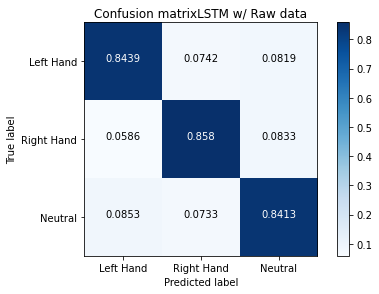

LSTM w/ SSA-Prep
KFold_1 accuracy: 62.32%
KFold_2 accuracy: 45.68%
KFold_3 accuracy: 74.36%
KFold_4 accuracy: 86.86%
KFold_5 accuracy: 91.27%
KFold_6 accuracy: 94.94%
KFold_7 accuracy: 97.06%
KFold_8 accuracy: 98.25%
KFold_9 accuracy: 94.39%
KFold_10 accuracy: 97.52%
Validated accuracy: 84.26% (+/- 0.17%)
Test set accuracy
accuracy: 74.60%


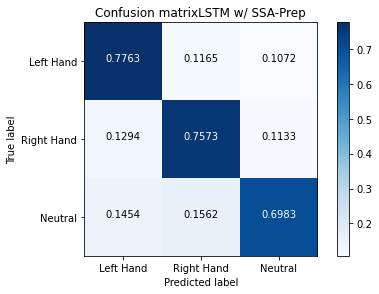

CNN-LSTM w/ Raw data
KFold_1 accuracy: 86.49%
KFold_2 accuracy: 94.67%
KFold_3 accuracy: 96.14%
KFold_4 accuracy: 96.60%
KFold_5 accuracy: 96.60%
KFold_6 accuracy: 96.97%
KFold_7 accuracy: 96.60%
KFold_8 accuracy: 96.42%
KFold_9 accuracy: 97.24%
KFold_10 accuracy: 96.60%
Validated accuracy: 95.43% (+/- 0.03%)
Test set accuracy
accuracy: 84.30%


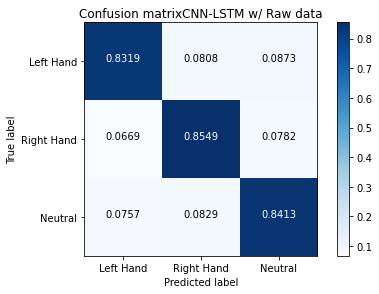

CNN-LSTM w/SSA-Prep
KFold_1 accuracy: 74.72%
KFold_2 accuracy: 95.68%
KFold_3 accuracy: 97.52%
KFold_4 accuracy: 98.16%
KFold_5 accuracy: 99.26%
KFold_6 accuracy: 98.99%
KFold_7 accuracy: 99.54%
KFold_8 accuracy: 99.45%
KFold_9 accuracy: 99.17%
KFold_10 accuracy: 99.82%
Validated accuracy: 96.23% (+/- 0.07%)
Test set accuracy
accuracy: 76.43%


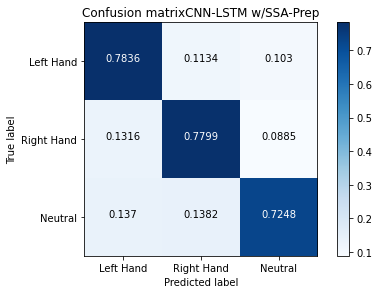

In [35]:
model_key ={
    'raw_1':{'key':'raw_lstm','epoch':50,'batch':100,'name':'LSTM w/ Raw data'},
    'ssa_1':{'key':'ssa_lstm','epoch':100,'batch':100,'name':'LSTM w/ SSA-Prep'},
    'raw_2':{'key':'raw_lstm_cnn','epoch':100,'batch':40,'name':'CNN-LSTM w/ Raw data'},
    'ssa_2':{'key':'ssa_lstm_cnn','epoch':100,'batch':100,'name':'CNN-LSTM w/SSA-Prep'}
}
results = worker(model_key)

In [8]:
model_key ={
    'raw_1':{'key':'raw_lstm','epoch':50,'batch':100},
    'ssa_1':{'key':'ssa_lstm','epoch':100,'batch':100},
    'raw_2':{'key':'raw_lstm_cnn','epoch':100,'batch':40},
    'ssa_2':{'key':'ssa_lstm_cnn','epoch':100,'batch':100}
}
results = worker(model_key)

raw_1
(9520, 200, 21)
(1360, 200, 21)
accuracy: 56.32%
(9520, 200, 21)
(1360, 200, 21)
accuracy: 74.85%
(9520, 200, 21)
(1360, 200, 21)
accuracy: 84.04%
(9520, 200, 21)
(1360, 200, 21)
accuracy: 90.81%
(9520, 200, 21)
(1360, 200, 21)
accuracy: 94.19%
(9520, 200, 21)
(1360, 200, 21)
accuracy: 93.75%
(9520, 200, 21)
(1360, 200, 21)
accuracy: 95.96%
(9520, 200, 21)
(1360, 200, 21)
accuracy: 96.32%
85.78% (+/- 13.06%)
ssa_1
(9520, 200, 6)
(1360, 200, 6)
accuracy: 68.90%
(9520, 200, 6)
(1360, 200, 6)
accuracy: 82.35%
(9520, 200, 6)
(1360, 200, 6)
accuracy: 88.97%
(9520, 200, 6)
(1360, 200, 6)
accuracy: 94.56%
(9520, 200, 6)
(1360, 200, 6)
accuracy: 96.32%
(9520, 200, 6)
(1360, 200, 6)
accuracy: 95.37%
(9520, 200, 6)
(1360, 200, 6)
accuracy: 95.81%
(9520, 200, 6)
(1360, 200, 6)
accuracy: 97.35%
89.95% (+/- 9.23%)
raw_2
(9520, 8, 25, 21)
(1360, 8, 25, 21)
accuracy: 85.00%
(9520, 8, 25, 21)
(1360, 8, 25, 21)
accuracy: 94.49%
(9520, 8, 25, 21)
(1360, 8, 25, 21)
accuracy: 95.96%
(9520, 8, 25, 21

In [10]:
results

{'raw_1': (85.78125014901161, 13.059336088221082),
 'ssa_1': (89.9540439248085, 9.234745457358137),
 'raw_2': (95.12867704033852, 3.9366993755648307),
 'ssa_2': (94.73345503211021, 7.8479468885810695)}

In [22]:
def worker_validation(model_dictionary,folds):
    cv_scores = {}
    for key,key_values in model_dictionary.items():
        print(key)
        X_train,y_train,X_test,y_test = load_dataset(key)
        model = model_selector(key_values['key'])
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(X_train,y_train,verbose=0,epochs=key_values['epoch'],batch_size=key_values['batch'])
        print('Train accuracy...')
        score = model.evaluate(X_train,y_train,verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
        cvscores = []
        for i in range(folds):
            ev = model.evaluate(X_test,y_test,verbose=0)
            print(ev[1])
            cvscores.append(ev[1]) 
        print('Validation accuracy')
        print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores)*100, np.std(cvscores)))    
        cv_scores[key] = (np.mean(cvscores),np.std(cvscores))
        disp_confusion_matrix(model,X__t,y__t,key_values['name'],class_label=['Left Hand','Right Hand','Neutral'])
    return cv_scores

In [36]:
model_key ={
    'raw_1':{'key':'raw_lstm','epoch':50,'batch':100},
    'ssa_1':{'key':'ssa_lstm','epoch':100,'batch':100},
    'raw_2':{'key':'raw_lstm_cnn','epoch':100,'batch':40},
    'ssa_2':{'key':'ssa_lstm_cnn','epoch':100,'batch':100}
}
results = worker_validation(model_key,folds=50)

raw_1
Train accuracy...
accuracy: 93.25%
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
0.7886029481887817
Validatio

In [39]:
def kfold_val(model,X,y,n_splits,model_epochs,model_batch_size,X__t,y__t,name):
    kfold = StratifiedKFold(n_splits=n_splits,shuffle=True)
    cvscores = []
    y = np.argmax(y,axis=1)+1
    i = 1
    for train,test in kfold.split(X,y):
        y_train =tf.keras.utils.to_categorical(y[train]-1)
        y_test =tf.keras.utils.to_categorical(y[test]-1)
        #Compile the model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        #Fit the model on the train split
        model.fit(X[train],y_train,verbose=0,epochs=model_epochs,batch_size=model_batch_size)
        #Evaluate the model
        score = model.evaluate(X[test],y_test,verbose=0)
        print(f'KFold_{i} '+"%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
        cvscores.append(score[1])
        i+=1
    print('Validated accuracy: '+"%.2f%% (+/- %.2f%%)" % (np.mean(cvscores)*100, np.std(cvscores)))
    #Validation set information
    print('Test set accuracy')
    ev = model.evaluate(X__t,y__t,verbose=0)[1]
    print("%s: %.2f%%" % (model.metrics_names[1], ev*100))
    disp_confusion_matrix(model,X__t,y__t,name,class_label=['Left Hand','Right Hand','Neutral'])
    return cvscores

LSTM w/ Raw data
KFold_1 accuracy: 76.01%
KFold_2 accuracy: 87.50%
KFold_3 accuracy: 92.56%
KFold_4 accuracy: 95.50%
KFold_5 accuracy: 94.94%
KFold_6 accuracy: 96.97%
KFold_7 accuracy: 97.06%
KFold_8 accuracy: 97.33%
KFold_9 accuracy: 98.25%
KFold_10 accuracy: 98.25%
Validated accuracy: 93.44% (+/- 0.07%)
Test set accuracy
accuracy: 83.49%


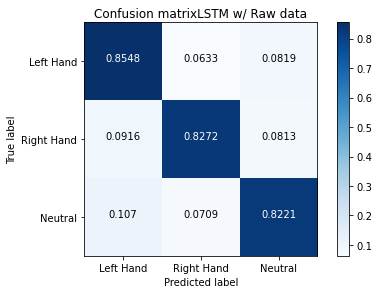

LSTM w/ SSA-Prep
KFold_1 accuracy: 71.32%
KFold_2 accuracy: 86.21%
KFold_3 accuracy: 90.44%
KFold_4 accuracy: 92.19%
KFold_5 accuracy: 95.50%
KFold_6 accuracy: 95.96%
KFold_7 accuracy: 97.89%
KFold_8 accuracy: 96.88%
KFold_9 accuracy: 96.88%
KFold_10 accuracy: 97.52%
Validated accuracy: 92.08% (+/- 0.08%)
Test set accuracy
accuracy: 74.60%


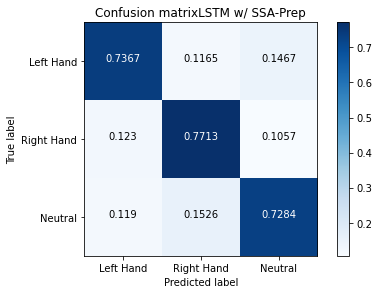

CNN-LSTM w/ Raw data
KFold_1 accuracy: 84.47%
KFold_2 accuracy: 95.22%
KFold_3 accuracy: 95.96%
KFold_4 accuracy: 96.23%
KFold_5 accuracy: 95.59%
KFold_6 accuracy: 97.61%
KFold_7 accuracy: 96.88%
KFold_8 accuracy: 97.61%
KFold_9 accuracy: 97.61%
KFold_10 accuracy: 95.50%
Validated accuracy: 95.27% (+/- 0.04%)
Test set accuracy
accuracy: 82.24%


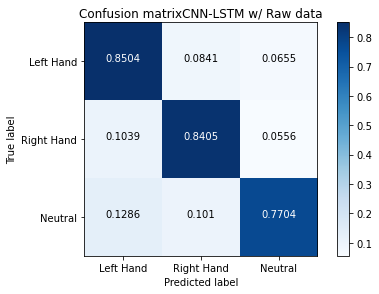

CNN-LSTM w/SSA-Prep
KFold_1 accuracy: 75.18%
KFold_2 accuracy: 94.03%
KFold_3 accuracy: 95.68%
KFold_4 accuracy: 98.62%
KFold_5 accuracy: 98.62%
KFold_6 accuracy: 99.08%
KFold_7 accuracy: 99.26%
KFold_8 accuracy: 98.25%
KFold_9 accuracy: 99.45%
KFold_10 accuracy: 99.45%
Validated accuracy: 95.76% (+/- 0.07%)
Test set accuracy
accuracy: 76.51%


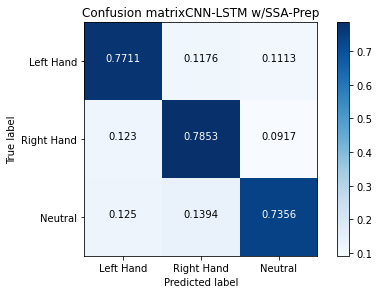

In [40]:
model_key ={
    'raw_1':{'key':'raw_lstm','epoch':50,'batch':100,'name':'LSTM w/ Raw data'},
    'ssa_1':{'key':'ssa_lstm','epoch':100,'batch':100,'name':'LSTM w/ SSA-Prep'},
    'raw_2':{'key':'raw_lstm_cnn','epoch':100,'batch':40,'name':'CNN-LSTM w/ Raw data'},
    'ssa_2':{'key':'ssa_lstm_cnn','epoch':100,'batch':100,'name':'CNN-LSTM w/SSA-Prep'}
}
results_s = worker(model_key)